In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'

import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure1'
misc.get_or_create_subdir(figdir)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)


'/mnt/home/szheng/ceph/place_variability/data/paper'

In [3]:
subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


In [13]:
subdb.index.get_level_values(0).nunique() # animal

11

In [16]:
subdb.shape # sess

(46, 12)

In [4]:
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['font.size'] = 10

In [5]:
import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

In [7]:
# subdb=subdb.iloc[:1]

In [6]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

pf_params_all = prepped_data_agg['pf_params_all']
all_fields_all = prepped_data_agg['all_fields_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 



In [6]:
# %%time
# all_fields_recombined_all = {}
# pf_params_recombined_all = {}
# fr_map_trial_df_all = {}
# pval_all = {}
# best_n_all = {}
# X_pwc_all = {}
# X_raw_all = {}
# changes_df_all = {}
# var_res_all = {}
# corr_all = {}
# all_sw_d_all = {}
# all_sw_with_metrics_d_all = {}
# trial_index_to_index_within_df_all = {}

# for ind,row in subdb.iterrows():
#     data_dir_full = row['data_dir_full']
#     ani = ind[0]
#     sess = row['sess_name']
    
#     res=dpp.load_spk_beh_df(data_dir_full,load_only=True)
#     if res is not None:
#         spk_beh_df = res['spk_beh_df']
#         trial_index_to_index_within_df = dpp.trial_index_to_index_within_trialtype(spk_beh_df)
#         trial_index_to_index_within_df_all[ani,sess] = trial_index_to_index_within_df
        

#     pf_res_recombine = pfrc.main(data_dir_full,force_reload=False,load_only=True)

#     all_fields_recombined=pf_res_recombine['all_fields_recombined']
#     all_fields_recombined_all[ani,sess] = all_fields_recombined
#     pf_params_recombined = pf_res_recombine['params_recombined']
#     pf_params_recombined_all[ani,sess] = pf_params_recombined

#     fr_map_all = fmos.main(data_dir_full,force_reload=False,load_only=True)
#     fr_map_trial_df = fr_map_all['fr_map_trial_df']
#     fr_map_trial_df_all[ani,sess] = fr_map_trial_df



#     sw_res = sdos.main(data_dir_full,force_reload=False,load_only=True)
#     pval = sw_res['pval']
#     pval_all[ani,sess]=pval
#     best_n = sw_res['best_n']
#     best_n_all[ani,sess] = best_n
#     X_pwc = sw_res['X_pwc']
#     X_pwc_all[ani,sess] = X_pwc
#     X_raw = sw_res['X_raw']
#     X_raw_all[ani,sess]=X_raw
#     changes_df = sw_res['changes_df']
#     changes_df_all[ani,sess] = changes_df
#     var_res = sw_res['var_res']
#     var_res_all[ani,sess]=var_res
#     corr = sw_res['corr']
#     corr_all[ani,sess] = corr

#     sw_info_res=gasam.main(data_dir_full,force_reload=False,load_only=True)
#     if sw_info_res is None:
#         sw_info_res=gasam.main(data_dir_full,force_reload=True,load_only=False)
#     all_sw_d = sw_info_res['all_sw_d']
#     all_sw_d_all[ani,sess] = all_sw_d
#     all_sw_with_metrics_d = sw_info_res['all_sw_with_metrics_d']
#     all_sw_with_metrics_d_all[ani,sess] = all_sw_with_metrics_d

# all_fields_recombined_all = pd.concat(all_fields_recombined_all,axis=0)
# pf_params_recombined_all = pd.concat(pf_params_recombined_all,axis=0)
# fr_map_trial_df_all = pd.concat(fr_map_trial_df_all,axis=0)
# pval_all = pd.concat(pval_all,axis=0)
# X_pwc_all = pd.concat(X_pwc_all,axis=0)
# X_raw_all = pd.concat(X_raw_all,axis=0)
# changes_df_all = pd.concat(changes_df_all,axis=0)
# var_res_all = pd.concat(var_res_all,axis=0)
# corr_all = pd.concat(corr_all,axis=0)
# all_sw_d_all = pd.concat(all_sw_d_all,axis=0)
# all_sw_with_metrics_d_all = pd.concat(all_sw_with_metrics_d_all,axis=0)
# best_n_all = pd.concat(best_n_all,axis=0)


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/fr_map_with_int.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/fr_map_with_int.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210302/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210302/py_data/fr_map_with_int.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210302/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210302/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/fr_map_with_int.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200919/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200919/py_data/fr_map_with_int.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200919/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200919/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/fr_map_with_int.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m

In [7]:
ntrials_per_sess=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])

In [8]:
ntrials_per_sess_trialtyp_summed=ntrials_per_sess.groupby(level=(0,1,2)).sum()
ntrials_mask = ntrials_per_sess_trialtyp_summed >= 20

# exp var ratio vs shuffle

In [39]:
# best_n_no_zero=pval.loc[:,(slice(None),'pval')].droplevel(axis=1,level=1).idxmin(axis=1)
# best_pval = pval.apply(lambda x:x[best_n_no_zero[x.name]],axis=1)

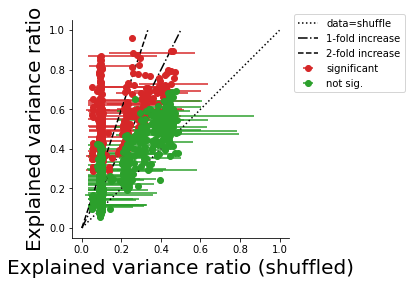

In [131]:
# %matplotlib inline
# fig,ax=plt.subplots()
# ax.set_aspect('equal')
# issig = best_n > 0
# c = [matplotlib.colors.to_rgb('C0') if i else matplotlib.colors.to_rgb('C0') for i in issig]
# c_dict = {True:'C3',False:'C2'}
# label_d = {True:'significant',False:'not sig.'}
# for tf in [True,False]:
#     ma = issig == tf
#     best_pval_ma = best_pval.loc[ma]
#     errorbar=best_pval_ma[['exp_var_ratio_sh_low','exp_var_ratio_sh_high']].T - best_pval_ma['exp_var_ratio_sh_med']
#     errorbar = [-errorbar.iloc[0],errorbar.iloc[1]]
#     c = c_dict[tf]
#     ax.errorbar(best_pval_ma['exp_var_ratio_sh_med'],best_pval_ma['exp_var_ratio'],xerr = errorbar,fmt='o',
#             errorevery=10,c=c,label=label_d[tf]
#            )
# ax.plot([0,1],[0,1],color='k',linestyle=':',label='data=shuffle')
# ax.plot([0,0.5],[0,1],color='k',linestyle='-.',label='1-fold increase')
# ax.plot([0,1/3],[0,1],color='k',linestyle='--',label='2-fold increase')
# ax.spines[['top','right']].set_visible(False)
# ax.set_xlabel('Explained variance ratio (shuffled)')
# ax.set_ylabel('Explained variance ratio')
# ax.legend(bbox_to_anchor=[1,1.05])


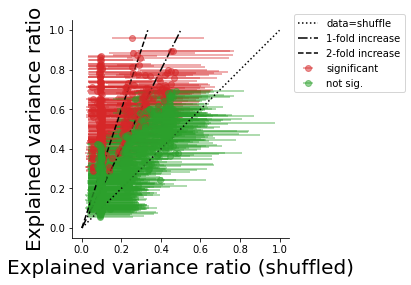

In [133]:
# %matplotlib inline
# fig,ax=plt.subplots()
# ax.set_aspect('equal')
# issig = best_n > 0
# c = [matplotlib.colors.to_rgb('C0') if i else matplotlib.colors.to_rgb('C0') for i in issig]
# c_dict = {True:'C3',False:'C2'}
# label_d = {True:'significant',False:'not sig.'}
# for tf in [True,False]:
#     ma = issig == tf
#     best_pval_ma = best_pval.loc[ma]
#     errorbar=best_pval_ma[['exp_var_ratio_sh_low','exp_var_ratio_sh_high']].T - best_pval_ma['exp_var_ratio_sh_med']
#     errorbar = [-errorbar.iloc[0],errorbar.iloc[1]]
#     c = c_dict[tf]
#     ax.errorbar(best_pval_ma['exp_var_ratio_sh_med'],best_pval_ma['exp_var_ratio'],xerr = errorbar,fmt='o',
#             errorevery=1,c=c,label=label_d[tf],alpha=0.5
#            )
# ax.plot([0,1],[0,1],color='k',linestyle=':',label='data=shuffle')
# ax.plot([0,0.5],[0,1],color='k',linestyle='-.',label='1-fold increase')
# ax.plot([0,1/3],[0,1],color='k',linestyle='--',label='2-fold increase')
# ax.spines[['top','right']].set_visible(False)
# ax.set_xlabel('Explained variance ratio (shuffled)')
# ax.set_ylabel('Explained variance ratio')
# ax.legend(bbox_to_anchor=[1,1.05])


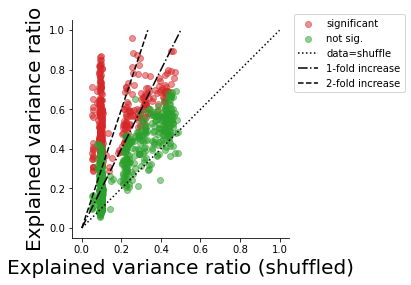

In [161]:
# %matplotlib inline
# fig,ax=plt.subplots()
# ax.set_aspect('equal')
# issig = best_n > 0
# c = [matplotlib.colors.to_rgb('C0') if i else matplotlib.colors.to_rgb('C0') for i in issig]
# c_dict = {True:'C3',False:'C2'}
# label_d = {True:'significant',False:'not sig.'}
# for tf in [True,False]:
#     ma = issig == tf
#     best_pval_ma = best_pval.loc[ma]
#     errorbar=best_pval_ma[['exp_var_ratio_sh_low','exp_var_ratio_sh_high']].T - best_pval_ma['exp_var_ratio_sh_med']
#     errorbar = [-errorbar.iloc[0],errorbar.iloc[1]]
#     c = c_dict[tf]
#     ax.scatter(best_pval_ma['exp_var_ratio_sh_med'],best_pval_ma['exp_var_ratio'],
#             c=c,label=label_d[tf],alpha=0.5
#            )
# ax.plot([0,1],[0,1],color='k',linestyle=':',label='data=shuffle')
# ax.plot([0,0.5],[0,1],color='k',linestyle='-.',label='1-fold increase')
# ax.plot([0,1/3],[0,1],color='k',linestyle='--',label='2-fold increase')
# ax.spines[['top','right']].set_visible(False)
# ax.set_xlabel('Explained variance ratio (shuffled)')
# ax.set_ylabel('Explained variance ratio')
# ax.legend(bbox_to_anchor=[1,1.05])


In [17]:
best_n_no_zero_all=pval_all.loc[:,(slice(None),'pval')].droplevel(axis=1,level=1).idxmin(axis=1)
best_pval_all = pval_all.apply(lambda x:x[best_n_no_zero_all[x.name]],axis=1)

In [26]:
best_pval_all.loc[(slice(None),slice(None),1)].index.get_level_values(1).nunique() # n novel sessions

8

In [27]:
best_pval_all.index.get_level_values(1).nunique() # n session

46

In [54]:
import matplotlib
def plot_exp_var_ratio_vs_shuffle(changes_df_all=None,best_n_all=None,pval_all=None,best_pval_all=None,figsize=(2.5,2.5)):
    if changes_df_all is not None: # prioritize using changes_df, which is more processed than best_n
        issig_all=((changes_df_all!=0)&(changes_df_all.notna())).sum(axis=1)>0
    elif best_n_all is not None:
        issig_all = best_n_all > 0
        
    if best_pval_all is None:
        best_n_no_zero_all=pval_all.loc[:,(slice(None),'pval')].droplevel(axis=1,level=1).idxmin(axis=1)
        best_pval_all = pval_all.apply(lambda x:x[best_n_no_zero_all[x.name]],axis=1)
    
    fig,ax=plt.subplots(figsize=figsize)
    ax.set_aspect('equal')
    
    c = [matplotlib.colors.to_rgb('C0') if i else matplotlib.colors.to_rgb('C0') for i in issig_all]
    c_dict = {True:'red',False:'blue'}
    label_d = {True:'significant',False:'not sig.'}
    for tf in [False,True]:
        ma = issig_all == tf
        best_pval_ma_all = best_pval_all.loc[ma]
    #     errorbar=best_pval_ma[['exp_var_ratio_sh_low','exp_var_ratio_sh_high']].T - best_pval_ma['exp_var_ratio_sh_med']
    #     errorbar = [-errorbar.iloc[0],errorbar.iloc[1]]
        c = c_dict[tf]
        ax.scatter(best_pval_ma_all['exp_var_ratio_sh_med'],best_pval_ma_all['exp_var_ratio'],
                c=c,label=label_d[tf],alpha=0.5,s=0.1,
               )
    ax.plot([0,1],[0,1],color='k',linestyle=':',label='data=shuffle')
    ax.plot([0,0.5],[0,1],color='k',linestyle='-.',label='1-fold increase')
    ax.plot([0,1/3],[0,1],color='k',linestyle='--',label='2-fold increase')
    ax.spines[['top','right']].set_visible(False)
    ax.set_xlabel('Explained variance ratio (shuffled)')
    ax.set_ylabel('Explained variance ratio')
    legend=ax.legend(bbox_to_anchor=[1,1.05],frameon=False)
    legend.legendHandles[0]._sizes = [30]
    legend.legendHandles[1]._sizes = [30]
    
    return best_pval_all, fig,ax




/tmp/ipykernel_2296194/510395295.py:34: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0]._sizes = [30]
/tmp/ipykernel_2296194/510395295.py:35: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1]._sizes = [30]


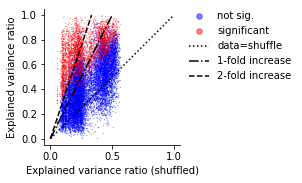

In [55]:
best_pval_all,fig,ax=plot_exp_var_ratio_vs_shuffle(changes_df_all=changes_df_all,pval_all=pval_all)
# ax.get_legend().set_visible(False)
figfn = 'exp_var_ratio_vs_shuffle'
# ph.save_given_name(fig,figfn,figdir)
# fn = os.path.join(figdir,'exp_var_ratio_vs_shuffle.svg')
# fig.savefig(fn,bbox_inches='tight')

In [56]:
has_sw=((changes_df_all!=0)&(changes_df_all.notna())).sum(axis=1)>0

In [66]:
((best_n_all>0).sum() - has_sw.sum() ) / (best_n_all>0).sum() # what fraction of switches were ruled out

0.06658291457286432

In [68]:
(best_n_all>0).sum() # number of putative switching fields at first

3184

In [70]:
has_sw_on=(changes_df_all==1).sum(axis=1)>0
has_sw_off=(changes_df_all==-1).sum(axis=1)>0

In [73]:
for isnovel in [0,1]:
    sub=has_sw.loc[(slice(None),slice(None),isnovel)]
    sub_on=has_sw_on.loc[(slice(None),slice(None),isnovel)]
    sub_off=has_sw_off.loc[(slice(None),slice(None),isnovel)]
    print(f'isnovel={isnovel} ')
    print(f'N={sub.shape[0]} ')
    print(f'N sig={sub.sum()} ')
    print(f'frac ={sub.mean()} ')
    print(f'N ON ={sub_on.sum()} ')
    print(f'frac ON ={sub_on.mean()} ')
    print(f'N OFF ={sub_off.sum()} ')
    print(f'frac OFF ={sub_off.mean()}\n')
    

          

isnovel=0 
N=12311 
N sig=2310 
frac =0.18763707253675574 
N ON =1740 
frac ON =0.1413370156770368 
N OFF =1106 
frac OFF =0.08983835594184063

isnovel=1 
N=2127 
N sig=662 
frac =0.31123648330982606 
N ON =526 
frac ON =0.24729666196520922 
N OFF =377 
frac OFF =0.1772449459332393



# frac significant per animal/session

In [23]:
from statannotations.Annotator import Annotator

In [24]:
has_sw=((changes_df_all!=0)&(changes_df_all.notna())).sum(axis=1)>0

In [25]:
# ratio_sig_per_sess = best_n_all.groupby(level=(0,1,2)).apply(lambda x:(x>0).mean())
ratio_sig_per_sess = has_sw.groupby(level=(0,1,2)).apply(lambda x:(x>0).mean())

ratio_sig_per_sess_reset_ind=ratio_sig_per_sess.reset_index()
ratio_sig_per_sess_reset_ind=ratio_sig_per_sess_reset_ind.rename({'level_0':'Animal','level_1':'Session','level_2':'Novel maze',0:'Frac. switching fields'},axis=1)

# seperate between ani with novel and ani without novel session
ani_with_novel = ratio_sig_per_sess_reset_ind.groupby(['Animal'])['Novel maze'].nunique() > 1

ratio_sig_per_sess_reset_ind['ani with novel']=ani_with_novel.loc[ratio_sig_per_sess_reset_ind['Animal']].values

xs = np.zeros(ratio_sig_per_sess_reset_ind.shape[0])
ma=np.logical_not(ratio_sig_per_sess_reset_ind['Novel maze'].astype(bool)) & np.logical_not(ratio_sig_per_sess_reset_ind['ani with novel'])
xs[ma]=0
ma=np.logical_not(ratio_sig_per_sess_reset_ind['Novel maze'].astype(bool)) & ratio_sig_per_sess_reset_ind['ani with novel']
xs[ma]=1
ma=(ratio_sig_per_sess_reset_ind['Novel maze']==1)
xs[ma]=2
ratio_sig_per_sess_reset_ind['xs'] = xs

In [26]:
def stripplot_with_median(data,x,y,fig=None,ax=None,reorder=False,color_per_strip=None,strip_kws={},ms=1,xticklabels_rotation=0,figsize=(2,3)):
    medians = data.groupby(x)[y].median()
    if reorder:
        medians=medians.sort_values(ascending=False)
    order = medians.index
        
    if ax is None:
        fig,ax=plt.subplots(figsize=figsize)
    if color_per_strip is None:
        ax = sns.stripplot(data=data,x=x,y=y,ax=ax,**strip_kws,order=order)
    else:
        gpb=data.groupby(x)
        for k,val in gpb:
            xs = k+np.random.normal(size=val.shape[0]) * 0.01
            ys = val[y]
            ax.scatter(xs,ys,c=color_per_strip[k],s=ms)
#             ax=sns.stripplot(data=val,x=x,y=y,color=color_per_strip[k])
    ax.spines[['top','right']].set_visible(False)
    xticklabels=ax.get_xticklabels()
    ax.set_xticklabels(xticklabels,rotation=xticklabels_rotation)
    
    for ii,(k,val) in enumerate(medians.iteritems()):
        ax.hlines(val,ii-0.2,ii+0.2,color='k')

    
    return fig,ax,order 
    
    

In [12]:
ratio_sig_per_sess_reset_ind

,Animal,Session,Novel maze,Frac. switching fields,ani with novel,xs
0,e13_16f1,e13_16f1_210302,0,0.200617,False,0.0
1,e13_16f1,e13_16f1_210312,0,0.131004,False,0.0
2,e13_16f1,e13_16f1_210314,0,0.130252,False,0.0
3,e13_16f1,e13_16f1_210317,0,0.102881,False,0.0
4,e13_16f1,e13_16f1_210319,0,0.151961,False,0.0
5,e13_16f1,e13_16f1_210322,0,0.181034,False,0.0
6,e13_16f1,e13_16f1_210328,0,0.151163,False,0.0
7,e13_16f1,e13_16f1_210331,0,0.116216,False,0.0
8,e13_26m1,e13_26m1_210913,0,0.373171,True,1.0
9,e13_26m1,e13_26m1_211019,0,0.271111,True,1.0


In [28]:
plt.rcParams['svg.fonttype']

'none'

In [19]:
ratio_sig_per_sess

e13_16f1  e13_16f1_210302  0    0.200617
          e13_16f1_210312  0    0.131004
          e13_16f1_210314  0    0.130252
          e13_16f1_210317  0    0.102881
          e13_16f1_210319  0    0.151961
          e13_16f1_210322  0    0.181034
          e13_16f1_210328  0    0.151163
          e13_16f1_210331  0    0.116216
e13_26m1  e13_26m1_210913  0    0.373171
          e13_26m1_211019  0    0.271111
                           1    0.326761
          e13_26m1_211116  0    0.130303
                           1    0.273504
          e13_26m1_211119  0    0.214953
                           1    0.493671
          e13_26m1_211124  0    0.220280
e14_2m2   e14_2m2_201017   0    0.175824
          e14_2m2_201019   0    0.134199
e14_2m3   e14_2m3_201118   0    0.154545
          e14_2m3_201121   0    0.094017
          e14_2m3_201125   0    0.109195
          e14_2m3_201129   0    0.150685
          e14_2m3_201206   0    0.157233
          e14_2m3_201208   0    0.183007
e15_10m1  e15_10

/tmp/ipykernel_2409262/3813294215.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels,rotation=xticklabels_rotation)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0 vs. 2.0: Mann-Whitney-Wilcoxon test two-sided, P_val:1.240e-02 U_stat=1.600e+01
0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:4.313e-05 U_stat=4.000e+01
0.0 vs. 2.0: Mann-Whitney-Wilcoxon test two-sided, P_val:1.737e-05 U_stat=1.700e+01


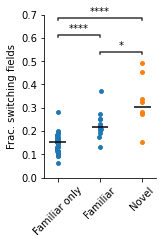

In [27]:

from matplotlib.lines import Line2D
data=ratio_sig_per_sess_reset_ind#ratio_sig_per_sess_reset_ind.drop(51) #unclear why drop 51.. go back to no drop
x='xs'#'Novel maze'
y='Frac. switching fields'
color_per_strip={0:'C0',1:'C0',2:'C1'}
fig,ax,order=stripplot_with_median(data,x,y,color_per_strip=color_per_strip,figsize=(2,3),ms=15)


ax.set_xticks([0,1,2])
ax.set_xticklabels(['Familiar only','Familiar','Novel'],fontsize=10,rotation=45)
ax.set_ylabel('Frac. switching fields')

pairs = [(0,2),(1,2),(0,1)]
annotator = Annotator(ax, pairs, data=data, x=x, y=y, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

legend_markers = [
    Line2D([0], [0], marker='o', color='w', label='familiar',
           markerfacecolor='C0', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='novel',
           markerfacecolor='C1', markersize=10)
]
# ax.legend(handles=legend_markers,bbox_to_anchor=[1,1.05],fontsize=15)
ax.set_ylim([0,0.7])

fn = os.path.join(figdir,'frac_switching_fields_vs_novel.svg')
fig.savefig(fn,bbox_inches='tight')

In [28]:
data.groupby('xs').median()

,Novel maze,Frac. switching fields,ani with novel
xs,,,
0.0,0.0,0.150924,0.0
1.0,0.0,0.217616,1.0
2.0,1.0,0.304890,1.0


In [30]:
data.groupby('xs').count()

,Animal,Session,Novel maze,Frac. switching fields,ani with novel
xs,,,,,
0.0,34,34,34,34,34
1.0,12,12,12,12,12
2.0,8,8,8,8,8


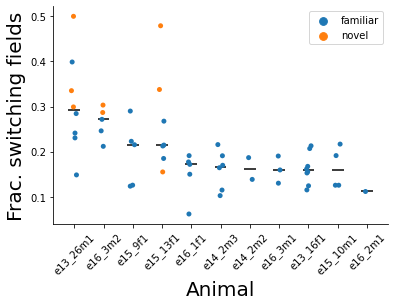

In [217]:
data=ratio_sig_per_sess_reset_ind
x='Animal'
y='Frac. switching fields'
fig,ax,ani_sorted=stripplot_with_median(data,x,y,strip_kws={'hue':'Novel maze'},reorder=True,xticklabels_rotation=45)
legend=ax.legend()
legend.set_title("")
legend.texts[0].set_text('familiar')
legend.texts[1].set_text('novel')
fn = os.path.join(figdir,'frac_switching_fields_vs_animal.svg')
fig.savefig(fn,bbox_inches='tight')

# n_neurons / n_trials vs frac switching 

In [218]:
nfields_per_session=all_fields_recombined_all.groupby(level=(0,1,2)).count().iloc[:,0].loc[ani_sorted]
ntrials_per_session=changes_df_all.groupby(level=(0,1,2)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])

sw_ratio_ntrials_fields_df = pd.concat({'Frac. switching fields':ratio_sig_per_sess,'N_trials':ntrials_per_session,'N_fields':nfields_per_session},axis=1)

sw_ratio_ntrials_fields_df=sw_ratio_ntrials_fields_df.reset_index(level=2).rename({'level_2':'Novel maze'},axis=1)


In [219]:
def regplot_seperate_hue(data,x,y,hue):
    fig,ax=plt.subplots()
    ax.spines[['top','right']].set_visible(False)
    ax=sns.regplot(data=data,x=x,y=y,ax=ax,scatter=False)
    ax=sns.scatterplot(data=data,x=x,y=y,hue=hue,ax=ax)
    y_center=data[y].mean()
    ax.axhline(y_center,color='k',linestyle=':')
    return fig,ax
    


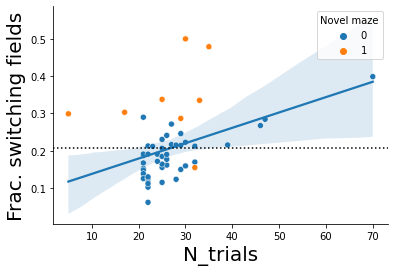

In [220]:
data=sw_ratio_ntrials_fields_df
x='N_trials'
y='Frac. switching fields'
hue='Novel maze'
fig,ax=regplot_seperate_hue(data,x,y,hue)

fn = os.path.join(figdir,'frac_switching_fields_vs_n_trials.svg')
fig.savefig(fn,bbox_inches='tight')

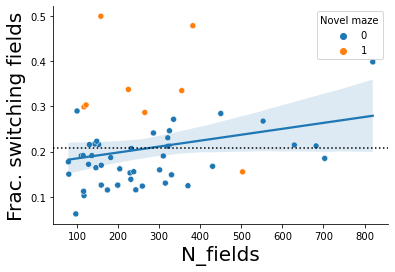

In [221]:
data=sw_ratio_ntrials_fields_df
x='N_fields'
y='Frac. switching fields'
hue='Novel maze'
fig,ax=regplot_seperate_hue(data,x,y,hue)

fn = os.path.join(figdir,'frac_switching_fields_vs_n_fields.svg')
fig.savefig(fn,bbox_inches='tight')

# debug example plot

In [84]:
ani = 'e13_26m1'
sess = 'e13_26m1_210913'

data_dir_full = subdb.loc[subdb['sess_name']==sess]['data_dir_full'][0]

fr_map_trial_df = fr_map_trial_df_all.loc[ani,sess]
all_fields_recombined = all_fields_recombined_all.loc[ani,sess]
all_sw_d = all_sw_d_all.loc[ani,sess]
all_sw_with_metrics_d = all_sw_with_metrics_d_all.loc[ani,sess]
trial_index_to_index_within_df = trial_index_to_index_within_df_all[ani,sess]
X_raw = X_raw_all.loc[ani,sess]
X_pwc = X_pwc_all.loc[ani,sess]
changes_df = changes_df_all.loc[ani,sess]
pf_params_recombined = pf_params_recombined_all.loc[ani,sess]

In [108]:

# all_fields_recombined.loc[0,0,141,1]
import plot_all_fr_map_x_pwc_one_session as plotfm
reload(plotfm)

<module 'plot_all_fr_map_x_pwc_one_session' from '/mnt/home/szheng/projects/place_variability/code/plot_all_fr_map_x_pwc_one_session.py'>

In [105]:
all_fields_recombined.iloc[800]

start                      15
end                        26
com                        20
peak                       19
fr_peak              3.951574
fr_mean              3.654688
other_field_index         0.0
Name: (0, both, 254, 1), dtype: object

(<Figure size 864x288 with 3 Axes>,
 array([<AxesSubplot:xlabel='Peak firing rate (Hz)', ylabel='Trial'>,
        <AxesSubplot:xlabel='Pos. bin'>], dtype=object))

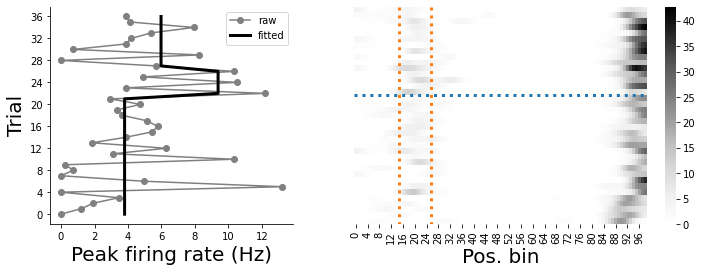

In [109]:
# all_fields_row_one = all_fields_recombined.loc[0,0,141,1]
# all_fields_row_one = all_fields_recombined.loc[0,1,480,0]
all_fields_row_one = all_fields_recombined.iloc[800]
plotfm.plot_ratemap_fr_one_field(all_fields_row_one,fr_map_trial_df,X_raw,X_pwc,all_sw_d,trial_index_to_index_within_df,
                            save_fig_fn = None,
                            close_fig = False,
                                )

In [118]:
ani='e13_26m1'
sess='e13_26m1_210913'
pval_all.loc[ani,sess].loc[0,0,454].loc[0,(slice(None),'pval')]

/tmp/ipykernel_564447/343789382.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  pval_all.loc[ani,sess].loc[0,0,454].loc[0,(slice(None),'pval')]


1  pval    0.003
2  pval    0.002
3  pval    0.000
4  pval    0.007
5  pval    0.009
Name: 0, dtype: float64

# visualize all place fields of potentially bad session

In [ ]:
# ani='e16_1f1'#'e15_13f1'
# sess='e16_1f1_200923'#'e16_3m2_211211'#'e15_13f1_220119'
# task_index=0
# fr_map_one=fr_map_trial_df_all.loc[ani,sess,task_index]

# task_index = 0
# uid_l=all_fields_recombined_all.loc[ani,sess,task_index].loc[0].index.get_level_values(0).unique()

# nplots=len(uid_l)
# fig,axs=ph.subplots_wrapper(nplots)
# for ii in range(nplots):
#     uid=uid_l[ii]
#     ax=axs.ravel()[ii]
#     ax=sns.heatmap(data=fr_map_one.loc[0].loc[uid].dropna(axis=1).T,cmap='Greys',ax=ax,cbar=False)
#     ax.set_title(uid)